In [1]:
! nvidia-smi

Fri Jun 23 13:56:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

!pip install torchsummary
!pip install tqdm
from tqdm import tqdm
from torchsummary import summary
import sys
import os
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

import utils
import model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [4]:
exp = datasets.CIFAR10('./data', train=True, download=True)
exp_data = exp.data

mean, std = utils.get_mean_and_std(exp_data)

print("Mean of the CIFAR10 dataset ", mean)
print("Standard Deviation of the CIFAR10 dataset ", std)

100%|██████████| 170498071/170498071 [00:13<00:00, 12876286.05it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
 - Dataset Numpy Shape: (50000, 32, 32, 3)
 - Min: [0. 0. 0.]
 - Max: [1. 1. 1.]
 - Mean: [0.49139968 0.48215841 0.44653091]
 - Std: [0.24703223 0.24348513 0.26158784]
 - Var: [15.56135559 15.11767693 17.44919073]
Mean of the CIFAR10 dataset  [0.49139968 0.48215841 0.44653091]
Standard Deviation of the CIFAR10 dataset  [0.24703223 0.24348513 0.26158784]


In [5]:
train_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.4914,0.4822,0.4465], [0.247, 0.243, 0.261])])

test_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.4914,0.4822,0.4465], [0.247, 0.243, 0.261])])

In [6]:
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


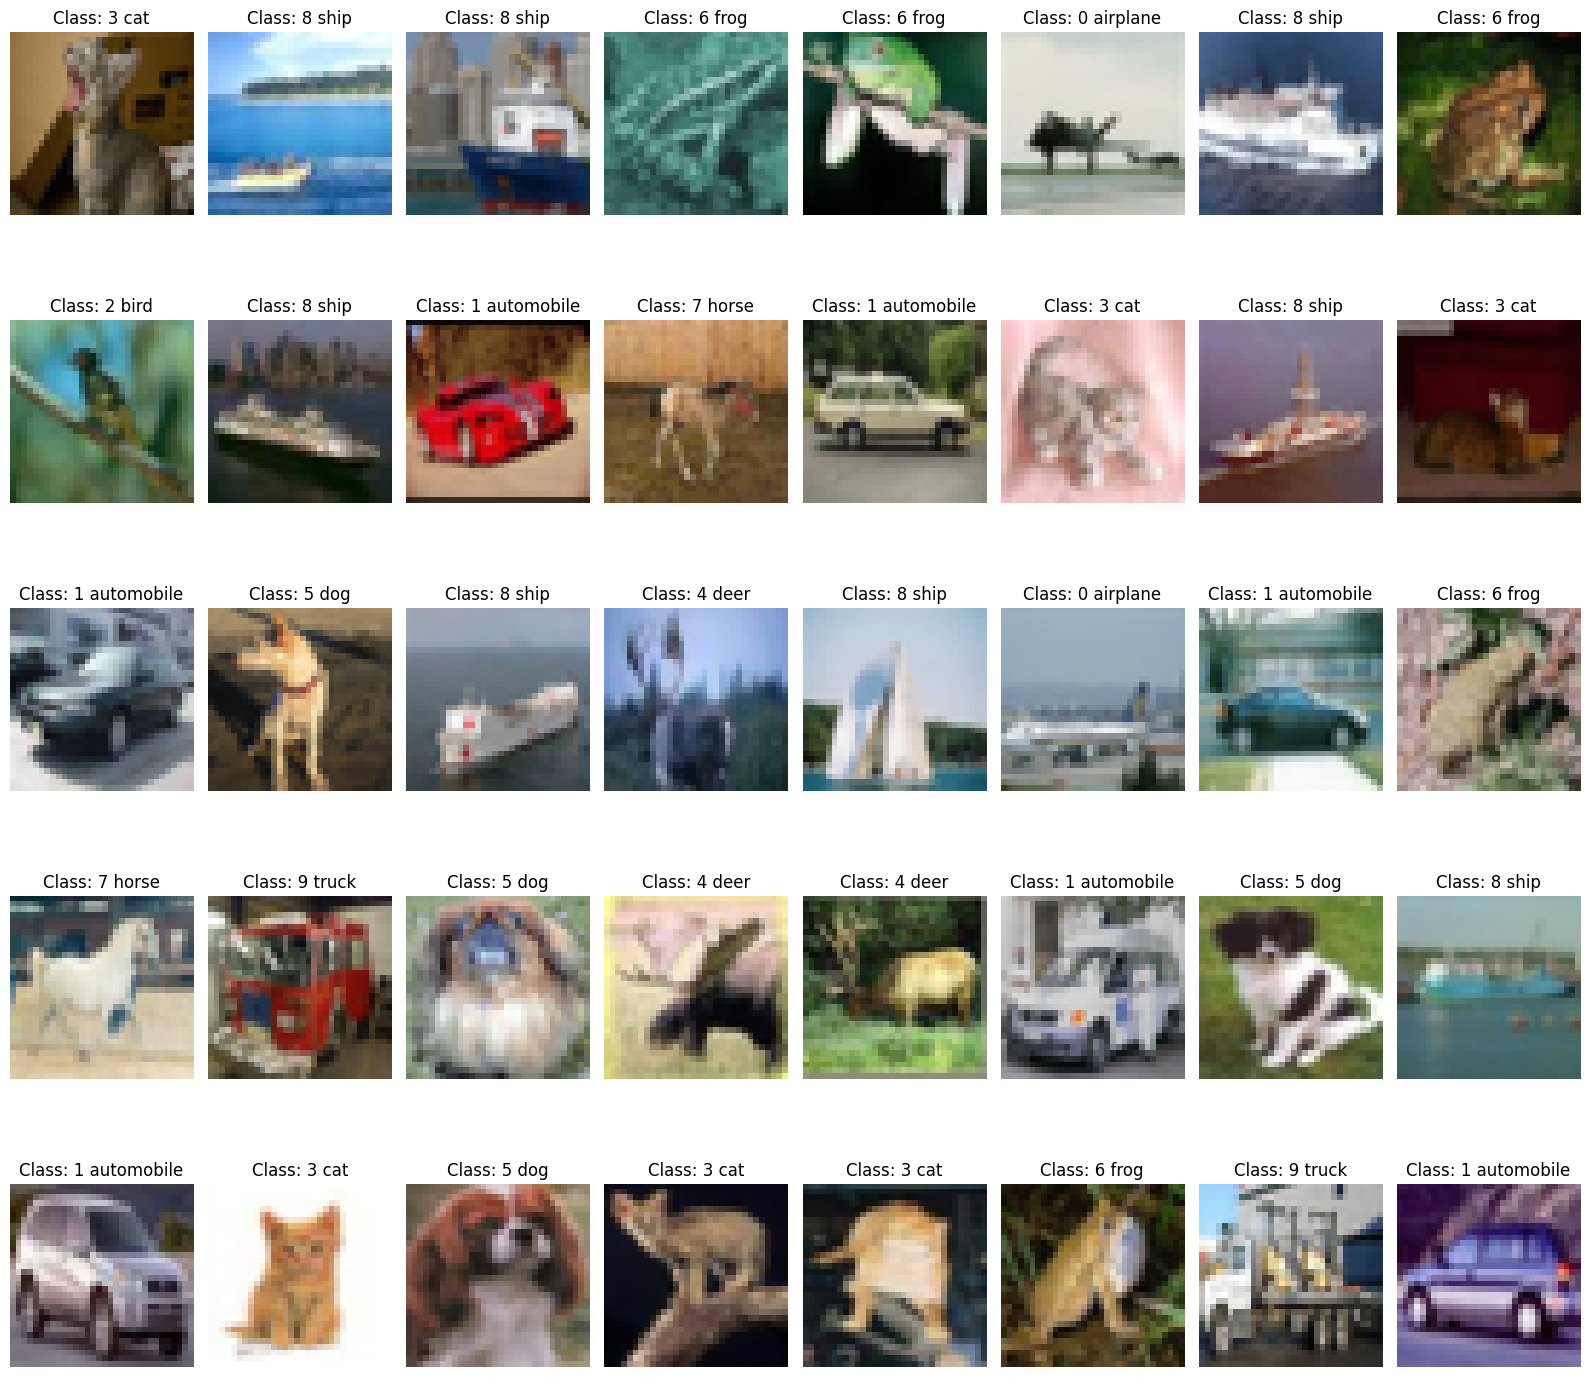

In [7]:
utils.plot_data(exp,5,8)

In [8]:
from model import Net
model = Net('bn').to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]           1,024
             ReLU-10           [-1, 16, 32, 32]               0
      BatchNorm2d-11           [-1, 16, 32, 32]              32
        MaxPool2d-12           [-1, 16, 16, 16]               0
           Conv2d-13           [-1, 32, 16, 16]           4,608
             ReLU-14           [-1, 32,

In [9]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

EPOCHS = 15
for epoch in range(1, EPOCHS+1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


Loss=1.2656543254852295 Batch_id=1562 Accuracy=44.06: 100%|██████████| 1563/1563 [00:30<00:00, 50.54it/s]



Test set: Average loss: 1.2791, Accuracy: 5375/10000 (53.75%)

EPOCH: 2


Loss=1.0846282243728638 Batch_id=1562 Accuracy=57.42: 100%|██████████| 1563/1563 [00:29<00:00, 52.34it/s]



Test set: Average loss: 1.0486, Accuracy: 6263/10000 (62.63%)

EPOCH: 3


Loss=1.2187632322311401 Batch_id=1562 Accuracy=62.30: 100%|██████████| 1563/1563 [00:30<00:00, 52.00it/s]



Test set: Average loss: 0.9155, Accuracy: 6814/10000 (68.14%)

EPOCH: 4


Loss=0.8776447772979736 Batch_id=1562 Accuracy=65.05: 100%|██████████| 1563/1563 [00:29<00:00, 53.29it/s]



Test set: Average loss: 0.8616, Accuracy: 6957/10000 (69.57%)

EPOCH: 5


Loss=1.1396918296813965 Batch_id=1562 Accuracy=67.23: 100%|██████████| 1563/1563 [00:31<00:00, 50.40it/s]



Test set: Average loss: 0.8455, Accuracy: 7023/10000 (70.23%)

EPOCH: 6


Loss=1.1381816864013672 Batch_id=1562 Accuracy=68.65: 100%|██████████| 1563/1563 [00:29<00:00, 53.16it/s]



Test set: Average loss: 0.8109, Accuracy: 7199/10000 (71.99%)

EPOCH: 7


Loss=0.84562087059021 Batch_id=1562 Accuracy=69.70: 100%|██████████| 1563/1563 [00:29<00:00, 52.85it/s]



Test set: Average loss: 0.8023, Accuracy: 7197/10000 (71.97%)

EPOCH: 8


Loss=1.0035806894302368 Batch_id=1562 Accuracy=71.05: 100%|██████████| 1563/1563 [00:30<00:00, 51.23it/s]



Test set: Average loss: 0.7543, Accuracy: 7353/10000 (73.53%)

EPOCH: 9


Loss=0.6715670824050903 Batch_id=1562 Accuracy=71.84: 100%|██████████| 1563/1563 [00:29<00:00, 52.34it/s]



Test set: Average loss: 0.7267, Accuracy: 7473/10000 (74.73%)

EPOCH: 10


Loss=0.6277309656143188 Batch_id=1562 Accuracy=72.83: 100%|██████████| 1563/1563 [00:30<00:00, 51.23it/s]



Test set: Average loss: 0.7189, Accuracy: 7544/10000 (75.44%)

EPOCH: 11


Loss=0.9567573070526123 Batch_id=1562 Accuracy=73.18: 100%|██████████| 1563/1563 [00:29<00:00, 52.44it/s]



Test set: Average loss: 0.7238, Accuracy: 7479/10000 (74.79%)

EPOCH: 12


Loss=0.46449801325798035 Batch_id=1562 Accuracy=73.60: 100%|██████████| 1563/1563 [00:31<00:00, 50.30it/s]



Test set: Average loss: 0.7237, Accuracy: 7489/10000 (74.89%)

EPOCH: 13


Loss=0.9918741583824158 Batch_id=1562 Accuracy=74.31: 100%|██████████| 1563/1563 [00:30<00:00, 51.95it/s]



Test set: Average loss: 0.6914, Accuracy: 7640/10000 (76.40%)

EPOCH: 14


Loss=0.742667555809021 Batch_id=1562 Accuracy=74.54: 100%|██████████| 1563/1563 [00:30<00:00, 51.91it/s]



Test set: Average loss: 0.6999, Accuracy: 7582/10000 (75.82%)

EPOCH: 15


Loss=1.2156281471252441 Batch_id=1562 Accuracy=75.04: 100%|██████████| 1563/1563 [00:30<00:00, 50.93it/s]



Test set: Average loss: 0.6671, Accuracy: 7741/10000 (77.41%)



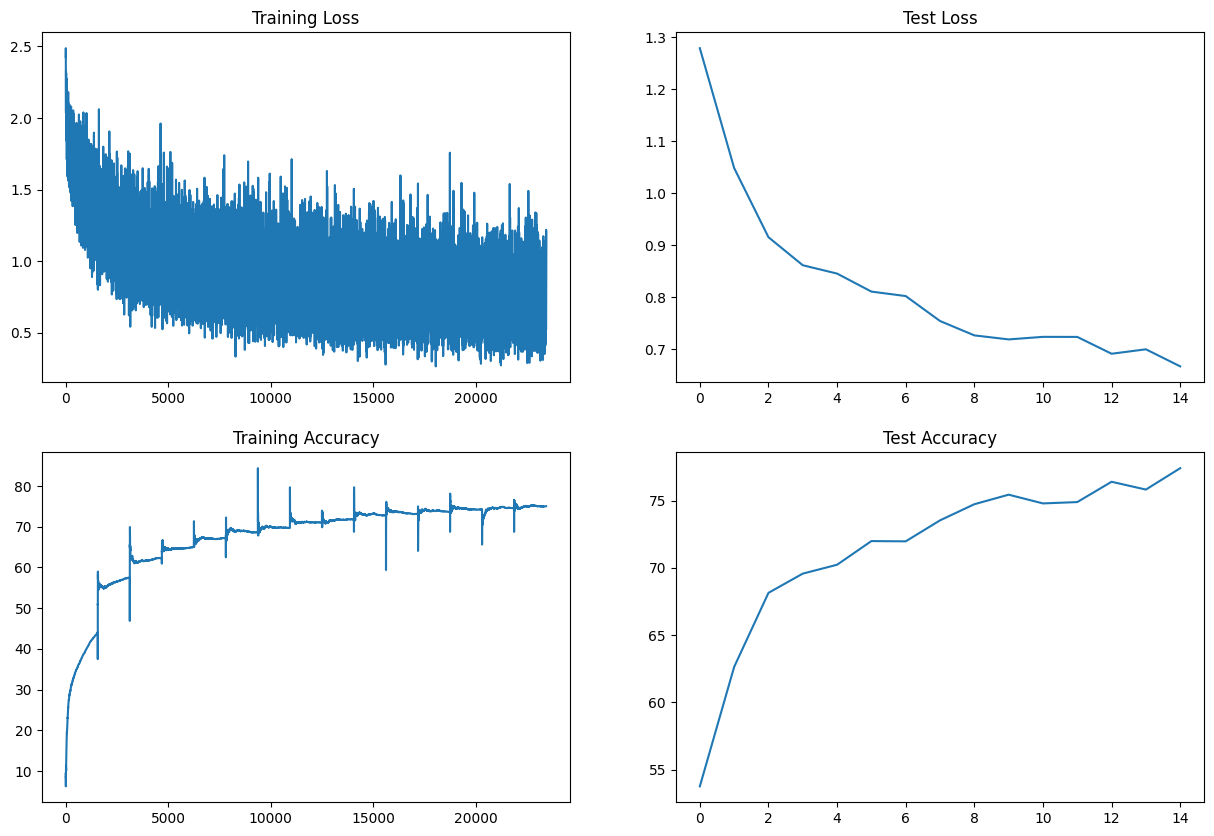

In [11]:
utils.draw_graphs(train_losses, train_acc, test_losses, test_acc)

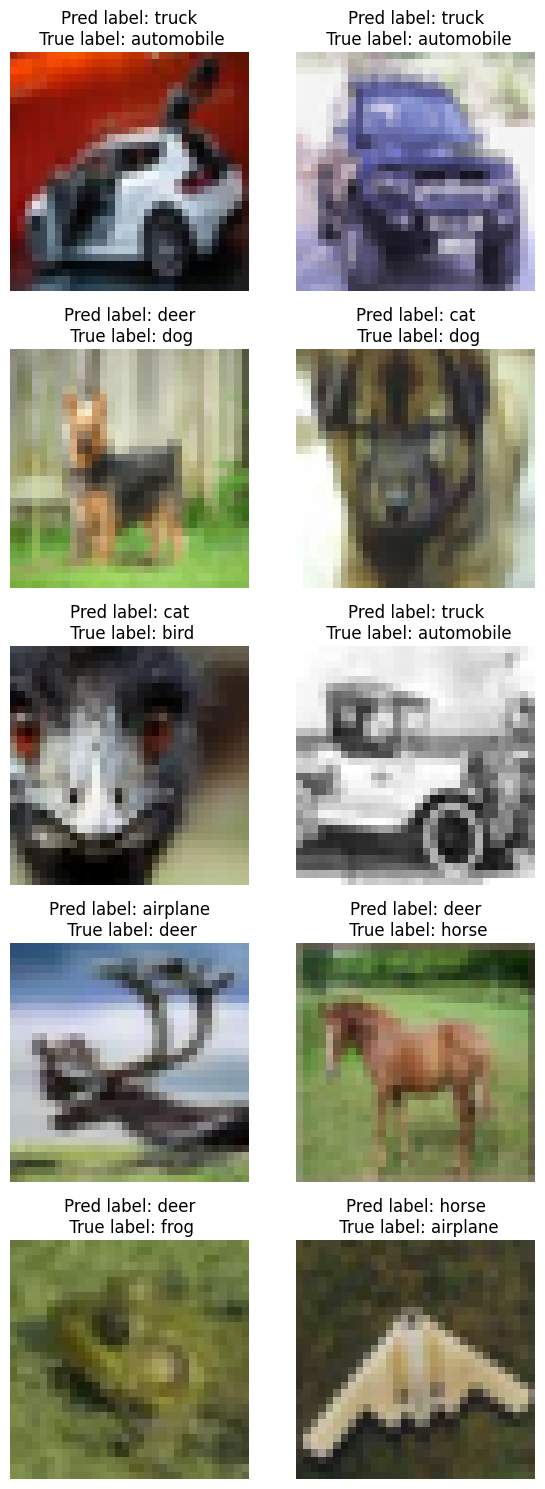

In [12]:
misclf = utils.plot_misclassified(model, test_loader, testset.classes, device, mean, std, no_misclf=10, plot_size=(5,2), return_misclf=True)